## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],drp_ratio=0.2, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
Dropout_EXP = [0.01,0.1]

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=5, 
                          verbose=1
                          )

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for dropout in itertools.product(Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout_EXP = %.6f" % (dropout))

    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dropout[0])

    #model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP[1])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-dropout-%s" % (str(dropout))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout_EXP = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2

50000/50000 [==============================] - 3s 65us/step - loss: 0.3520 - acc: 0.8847 - val_loss: 2.1897 - val_acc: 0.4597
Epoch 47/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.3393 - acc: 0.8891 - val_loss: 2.1615 - val_acc: 0.4625
Epoch 48/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.3229 - acc: 0.8948 - val_loss: 2.3644 - val_acc: 0.4463
Epoch 49/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.3191 - acc: 0.8951 - val_loss: 2.3234 - val_acc: 0.4469
Epoch 50/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.3140 - acc: 0.8957 - val_loss: 2.2730 - val_acc: 0.4541
Experiment with Dropout_EXP = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dens

50000/50000 [==============================] - 3s 67us/step - loss: 1.0022 - acc: 0.6402 - val_loss: 1.3918 - val_acc: 0.5212
Epoch 42/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9911 - acc: 0.6448 - val_loss: 1.4112 - val_acc: 0.5149
Epoch 43/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.9820 - acc: 0.6473 - val_loss: 1.4857 - val_acc: 0.5007
Epoch 44/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9758 - acc: 0.6522 - val_loss: 1.4493 - val_acc: 0.5085
Epoch 45/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9717 - acc: 0.6528 - val_loss: 1.4279 - val_acc: 0.5130
Epoch 46/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.9628 - acc: 0.6562 - val_loss: 1.4247 - val_acc: 0.5124
Epoch 47/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.9610 - acc: 0.6578 - val_loss: 1.4265 - val_acc: 0.5158
Epoch 48/50
50000/50000 [=====================

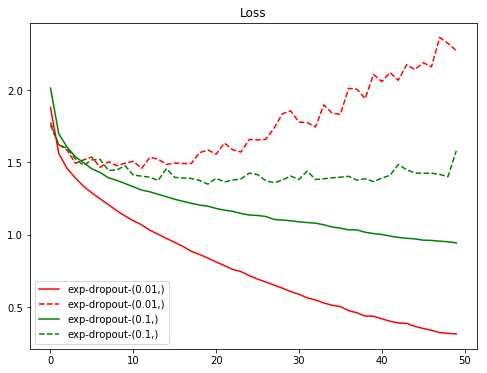

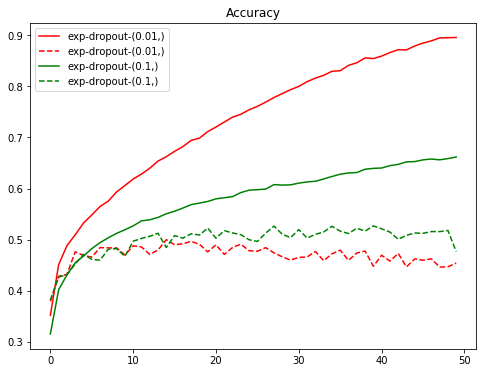

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
Dropout_EXP = [0.01,0.1]

from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_acc", 
                          patience=5, 
                          verbose=1
                          )

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for dropout in itertools.product(Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout_EXP = %.6f" % (dropout))

    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dropout[0])

    #model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP[1])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-dropout-%s" % (str(dropout))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout_EXP = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2

Epoch 47/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.3410 - acc: 0.8884 - val_loss: 2.1021 - val_acc: 0.4798
Epoch 48/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.3300 - acc: 0.8922 - val_loss: 2.1893 - val_acc: 0.4742
Epoch 49/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.3173 - acc: 0.8978 - val_loss: 2.1838 - val_acc: 0.4619
Epoch 50/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.3082 - acc: 0.9013 - val_loss: 2.1960 - val_acc: 0.4690
Experiment with Dropout_EXP = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normali

Epoch 43/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9962 - acc: 0.6435 - val_loss: 1.3988 - val_acc: 0.5196
Epoch 44/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9948 - acc: 0.6423 - val_loss: 1.3800 - val_acc: 0.5216
Epoch 45/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9896 - acc: 0.6476 - val_loss: 1.4388 - val_acc: 0.5015
Epoch 46/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9823 - acc: 0.6495 - val_loss: 1.4509 - val_acc: 0.5120
Epoch 47/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.9685 - acc: 0.6534 - val_loss: 1.3861 - val_acc: 0.5225
Epoch 48/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.9602 - acc: 0.6555 - val_loss: 1.4143 - val_acc: 0.5147
Epoch 49/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.9588 - acc: 0.6578 - val_loss: 1.4508 - val_acc: 0.5046
Epoch 50/50
50000/50000 [=========

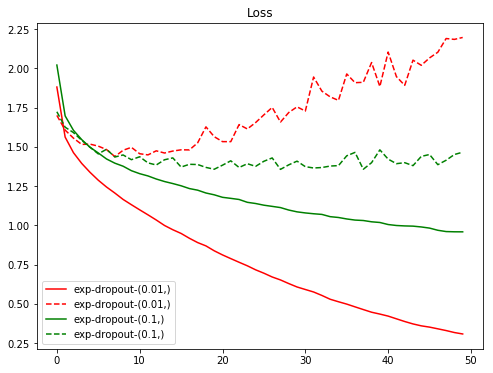

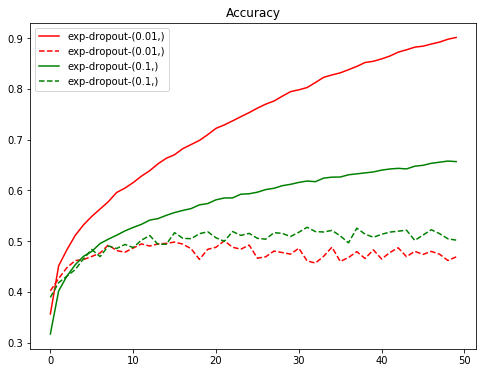

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()